# DFT with GPAW and ASE ##

Installing Atomic Simulation Environment (ASE) and GPAW

In [1]:
%%capture
!apt install python3-mpi4py cython3 libxc-dev gpaw-data
!pip -q install gpaw

## 1. Total energy of H$_2$ and Convergence

In [2]:
from ase import Atoms
from ase.io import read, write
from ase.visualize import view
from gpaw import GPAW, PW
import time

h2 = Atoms('H2', [(0, 0, 0), (0, 0, 0.74)])
h2.center(vacuum=2.5)
print(h2.cell)
print(h2.positions)
view(h2, viewer='x3d')

Cell([5.0, 5.0, 5.74])
[[2.5  2.5  2.5 ]
 [2.5  2.5  3.24]]


Testing for energy cutoff convergence

In [3]:
cutoffs = [200, 300, 400, 500, 1000]
times = []
energies = []

for cutoff in cutoffs:
  start_time = time.time()
  calc = GPAW(xc='LDA',
              kpts=(1,1,1),
              mode=PW(cutoff),
              txt='h2.txt')
  h2.calc = calc
  energies.append(h2.get_potential_energy())
  times.append(time.time() - start_time)
print(times)  # seconds
print(energies)  # eV

[1.5184223651885986, 0.8811547756195068, 1.6623380184173584, 2.3409390449523926, 4.09794545173645]
[np.float64(-6.36837060117049), np.float64(-6.5662807561202055), np.float64(-6.693834722327363), np.float64(-6.7317890739895185), np.float64(-6.750055588974419)]


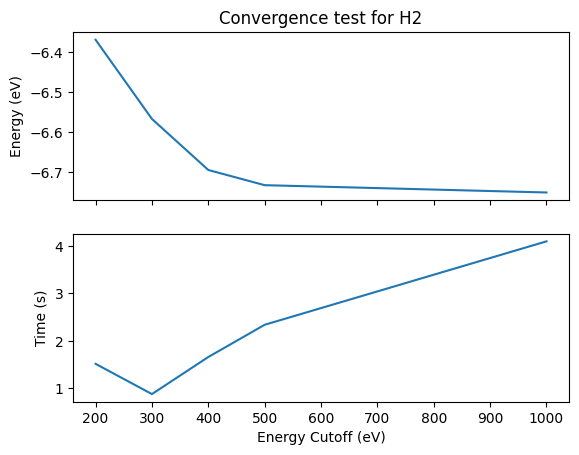

In [4]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(2, sharex=True)
ax[0].plot(cutoffs, energies)
ax[0].set_ylabel('Energy (eV)')
ax[0].set_title('Convergence test for H2')

ax[1].plot(cutoffs, times)
ax[1].set_ylabel('Time (s)')
ax[1].set_xlabel('Energy Cutoff (eV)')

plt.show()

Calculating the electron density and plotting a contour plot

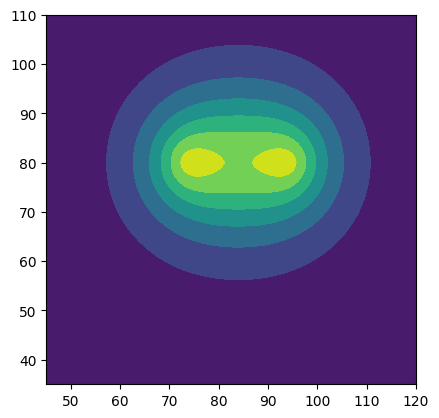

In [5]:
import numpy as np

n = calc.get_all_electron_density(gridrefinement=4)

nred = np.sum(n, axis=0) #sum over density in x-direction
#print(np.shape(nred))

fig, ax = plt.subplots()
ax.contourf(nred)
ax.set_xlim([45, 120])
ax.set_ylim([35, 110])
ax.set_aspect(1)
plt.show()

## 2. Atomization energy of H<sub>2</sub> ##

In [6]:
from ase import Atoms
from gpaw import GPAW, PW

cutoff = 500 # specify energy cutoff as obtained from previous convergence test
xcf = 'LDA'

a = 10.  # Size of unit cell (Angstrom)
c = a / 2 # Position atom(s) in center of cell

# Hydrogen molecule:
d = 0.74  # Experimental bond length
h2 = Atoms('H2',
           positions=([c - d / 2, c, c],
                      [c + d / 2, c, c]),
           cell=(a, a, a))

h2.calc = GPAW(xc=xcf, kpts=(1,1,1), mode=PW(cutoff), txt='h2.txt')

energy_h2 = h2.get_potential_energy()
print('E_H2 = ' + str(energy_h2))

E_H2 = -6.673739465554996


Now, let us calculate the energy of a single Hydrogen

In [7]:
# Hydrogen atom:
h = Atoms('H', positions=[(c, c, c)], cell=(a, a, a))

h.calc = GPAW(xc=xcf, kpts=(1,1,1), mode=PW(cutoff), hund=True, txt='h2.txt')

energy_h = h.get_potential_energy()
print('E_H = ' + str(energy_h))

E_H = -0.894218207814791


$E_\mathrm{bond}=2\cdot E_\mathrm{H}-E_{\mathrm{H}_2}$

In [8]:
print('E_bond = ' + str(2*energy_h-energy_h2))

E_bond = 4.8853030499254135


Experimental value: 4.51 eV

How do LDA and PBE compare to the experimental value?

## 3. Convergence tests for elemental transition metal crystal ##

The structures of pure/elemental (transition) metal crystals are easy to describe because the atoms that form these metals can be thought of as identical perfect spheres. The same can be said about the structure of the rare gases at very low temperatures. These substances crystallize in one of four basic structures that arise from closely packing spheres:
Simple cubic (SC), body-centered cubic (BCC), hexagonal closest-packed (HCP), and face-centered cubic (FCC, sometimes called cubic closest-packed or CCP).

For this interactive part, each person should pick a transition metal from this [Google Sheet](https://docs.google.com/spreadsheets/d/1k-IVM19sam8yz6aHg749r1GZKuw5UDr4KR83n25_YJc/).

In [9]:
from ase import Atoms
from ase.build import bulk
from ase.io import read, write
from gpaw import GPAW, PW
import time

element = 'Cu'

material = bulk(element, 'bcc', a=3)
view(material, viewer="x3d")

Again, let us test for convergence w.r.t. energy cutoff

In [10]:
cutoffs = [200, 300, 400, 500, 1000]
times = []
energies = []

for cutoff in cutoffs:
  start_time = time.time()
  calc = GPAW(xc='LDA',
              kpts=(5,5,5),
              mode=PW(cutoff),
              txt='material.txt')
  material.calc = calc
  energies.append(material.get_potential_energy())
  times.append(time.time() - start_time)

print(times)  # seconds
print(energies)  # eV

[2.4492790699005127, 3.6712965965270996, 5.166407823562622, 4.8420422077178955, 9.87014389038086]
[np.float64(-1.9759220800072737), np.float64(-4.142395064658556), np.float64(-4.31464108827872), np.float64(-4.432870590990807), np.float64(-4.486001484759413)]


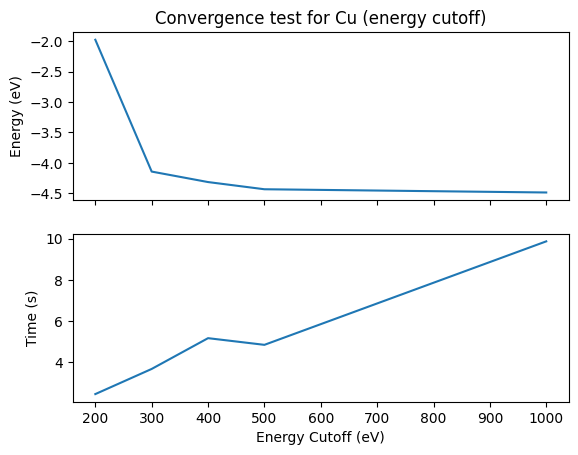

In [11]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(2, sharex=True)
ax[0].plot(cutoffs, energies)
ax[0].set_ylabel('Energy (eV)')
ax[0].set_title('Convergence test for ' + element + ' (energy cutoff)')

ax[1].plot(cutoffs, times)
ax[1].set_ylabel('Time (s)')
ax[1].set_xlabel('Energy Cutoff (eV)')

plt.show()

And now, convergence w.r.t. number of *k*-points

In [12]:
cutoff = 500
nkpt = list(range(1, 10))
times_n = []
energies_n = []

for n in nkpt:
  start_time = time.time()
  calc = GPAW(xc='LDA',
              kpts=(n,n,n),
              mode=PW(cutoff),
              txt='material.txt')
  material.calc = calc
  energies_n.append(material.get_potential_energy())
  times_n.append(time.time() - start_time)

print(times_n)  # seconds
print(energies_n)  # eV

[1.3425707817077637, 1.8299908638000488, 2.7076199054718018, 5.1223671436309814, 4.724853992462158, 6.667211532592773, 8.834285259246826, 11.41849946975708, 17.334874391555786]
[np.float64(-13.551563646090374), np.float64(-4.784410722472634), np.float64(-4.7265980730560155), np.float64(-4.421964422695497), np.float64(-4.432870590990807), np.float64(-4.44277675547272), np.float64(-4.42105727582243), np.float64(-4.440310489544152), np.float64(-4.4203835517793095)]


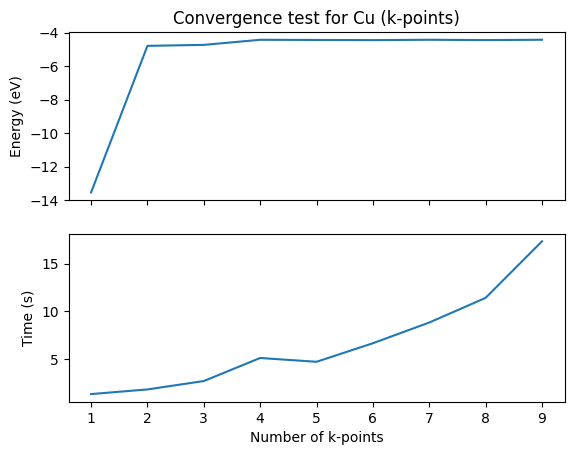

In [13]:
f, ax = plt.subplots(2, sharex=True)
ax[0].plot(nkpt, energies_n)
ax[0].set_ylabel('Energy (eV)')
ax[0].set_title('Convergence test for ' + element + ' (k-points)')

ax[1].plot(nkpt, times_n)
ax[1].set_ylabel('Time (s)')
ax[1].set_xlabel('Number of k-points')

plt.show()

Note down the the lowest cutoff energy and number of k-points that you assess converge the energy calculation

## 4. Determining the equilibrium lattice constant and structure ##

Now that we have the convergence parameters, we will try to calculate the lattice constant of the transition metal you picked.
For that we carry out several calculations while slightly changing the lattice constant.

Begin by picking a wider range for the lattice constant, e.g. `np.linspace(3,6,10)`. Once you found the approximate lattice constant then you can come back here and pick a narrower range.

In [14]:
import numpy as np

In [15]:
from ase import Atoms
from gpaw import GPAW, PW
from ase.build import bulk

energies = []
lattice_constants = np.linspace(2.5, 3.5, 10)

for a in lattice_constants:
  material = bulk(element, 'fcc', a)
  material.calc = GPAW(xc='LDA', kpts=(4,4,4), mode=PW(500), txt='gpaw.txt')
  energies.append(material.get_potential_energy())
print(energies)


[np.float64(15.615448849494694), np.float64(8.861844515178168), np.float64(4.162818065200119), np.float64(0.9366473196174379), np.float64(-1.244367085373007), np.float64(-2.6887897841301673), np.float64(-3.613313176865452), np.float64(-4.170607257831535), np.float64(-4.46963505723606), np.float64(-4.585763849322081)]


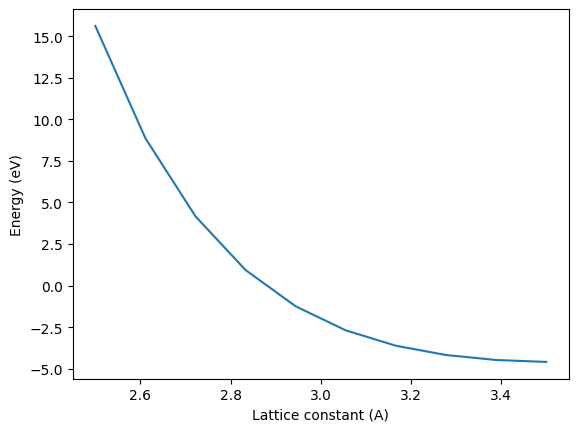

In [16]:
import matplotlib.pyplot as plt
plt.plot(lattice_constants, energies)
plt.xlabel('Lattice constant (A)')
plt.ylabel('Energy (eV)')
plt.show()

If that plot looks roguhly parabolic and has a minimum, let us get the lattice constant at the minimum energy.
Otherwise, adjust the range of your `lattice_constants` variable.<br/>
More correctly, one would plot the energy vs. the unit cell volume and then fit a parabolic curve ([equation of state](https://wiki.fysik.dtu.dk/ase/tutorials/eos/eos.html)) to it. Regardless, for our purposes, it gives us the optimal lattice constant.

In [17]:
print(min(energies))
print(lattice_constants[energies.index(min(energies))]) # The part in the square brackets returns the list index at which the list `energies` has its minimum

-4.585763849322081
3.5


In [21]:
# Now scan BCC structure
energies_bcc = []
lattice_constants_bcc = np.linspace(2.5, 3.5, 10)

for a in lattice_constants_bcc:
  material = bulk(element, 'bcc', a)
  material.calc = GPAW(xc='LDA', kpts=(4,4,4), mode=PW(500), txt='gpaw.txt')
  energies_bcc.append(material.get_potential_energy())

print("BCC energies:", energies_bcc)
print("BCC minimum energy:", min(energies_bcc))
print("BCC optimal lattice constant:", lattice_constants_bcc[energies_bcc.index(min(energies_bcc))])

BCC energies: [np.float64(-3.5163388323779565), np.float64(-4.239956758362913), np.float64(-4.559914160978991), np.float64(-4.6187798804186535), np.float64(-4.5148344724089355), np.float64(-4.310952614213486), np.float64(-4.054218520430417), np.float64(-3.769168143248572), np.float64(-3.475048984963479), np.float64(-3.184662800575416)]
BCC minimum energy: -4.6187798804186535
BCC optimal lattice constant: 2.8333333333333335


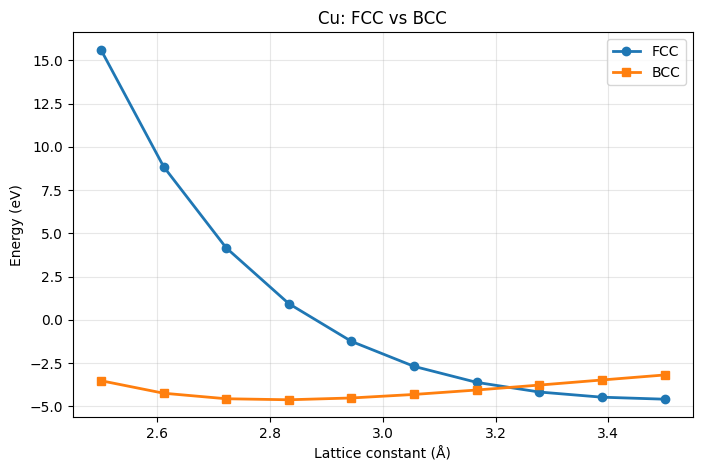

In [23]:
plt.figure(figsize=(8, 5))
plt.plot(lattice_constants, energies, 'o-', label='FCC', linewidth=2)
plt.plot(lattice_constants_bcc, energies_bcc, 's-', label='BCC', linewidth=2)
plt.xlabel('Lattice constant (Å)')
plt.ylabel('Energy (eV)')
plt.title(f'{element}: FCC vs BCC')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Once you found the lattice constant for one structure, try the other structure (both FCC and BCC).

## 5. Calculating the energy band structure along a high symmetry path in the first Brillouin zone ##

First, we calculate the ground state electron density for the optimized transition metal structure (either fcc or bcc; with the minimum energy lattice constant).

In [18]:
from ase.build import bulk
from gpaw import GPAW, PW, FermiDirac

element = 'Cu'
lattice = 'fcc' # or bcc
a = 3.5 # Lattice constant that you just determined

material = bulk(element, lattice, a)

calc = GPAW(mode=PW(500),
            xc='LDA',
            kpts=(4,4,4),
            random=True,  # random guess (needed if many empty bands required)
            occupations=FermiDirac(0.01), # Fermi smearing improves convergence for band calculations
            txt=element + '_gs.txt')

material.calc = calc
material.get_potential_energy()
calc.write('gs.gpw')

For the fixed ground state electron density (called non-self consistent field; nscf) we just calculated we now calculate the energy bands along a high-symmetry path in the 1st Brillouin zone. This is done by loading the calculation output file from before `gs.gpw` and by adding running the `fixed_density` function.

In [19]:
calc = GPAW('gs.gpw').fixed_density(
    nbands=16,
    symmetry='off',
    kpts={'path': 'GXWKL', 'npoints': 60},
    convergence={'bands': 8})


  ___ ___ ___ _ _ _  
 |   |   |_  | | | | 
 | | | | | . | | | | 
 |__ |  _|___|_____|  25.7.0
 |___|_|             

User:   ???@4df3cfb2968f
Date:   Mon Nov 24 18:18:30 2025
Arch:   x86_64
Pid:    233
CWD:    /content
Python: 3.12.12
gpaw:   /usr/local/lib/python3.12/dist-packages/gpaw
_gpaw:  /usr/local/lib/python3.12/dist-packages/
        _gpaw.cpython-312-x86_64-linux-gnu.so
ase:    /usr/local/lib/python3.12/dist-packages/ase (version 3.26.0)
numpy:  /usr/local/lib/python3.12/dist-packages/numpy (version 2.0.2)
scipy:  /usr/local/lib/python3.12/dist-packages/scipy (version 1.16.3)
libxc:  5.1.7
units:  Angstrom and eV
cores: 1
OpenMP: False
OMP_NUM_THREADS: 1

Input parameters:
  convergence: {bands: 8}
  gpts: [14 14 14]
  kpts: {npoints: 60,
         path: GXWKL}
  mode: {ecut: 500.0,
         name: pw}
  nbands: 16
  occupations: {name: fermi-dirac,
                width: 0.01}
  random: True
  symmetry: off

Initialize ...

species:
  Cu:
    name: Copper
    id: 0f0e166f2a1

ASE can create and handle k-point paths in different crystal structures/symmetries. More details here: https://wiki.fysik.dtu.dk/ase/ase/dft/kpoints.html <br/>
Let's plot the band structure!

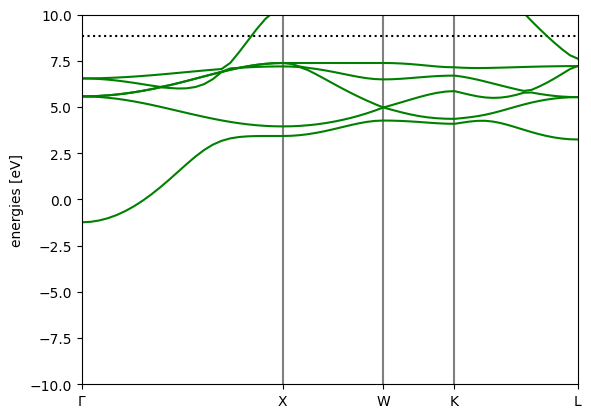

<Axes: ylabel='energies [eV]'>

In [20]:
bs = calc.band_structure()
bs.plot(filename='bandstructure.png', show=True, emax=10.0)

In [24]:
from ase.build import bulk
from gpaw import GPAW, PW, FermiDirac

element = 'Cu'
lattice = 'bcc' # or fcc
a = 2.83 # Lattice constant that you just determined

material = bulk(element, lattice, a)

calc = GPAW(mode=PW(500),
            xc='LDA',
            kpts=(4,4,4),
            random=True,  # random guess (needed if many empty bands required)
            occupations=FermiDirac(0.01), # Fermi smearing improves convergence for band calculations
            txt=element + '_gs.txt')

material.calc = calc
material.get_potential_energy()
calc.write('gs.gpw')

Timing:                              incl.     excl.
-----------------------------------------------------------
Hamiltonian:                         0.019     0.001   0.0% |
 Atomic:                             0.013     0.001   0.0% |
  XC Correction:                     0.012     0.012   0.0% |
 Calculate atomic Hamiltonians:      0.001     0.001   0.0% |
 Communicate:                        0.000     0.000   0.0% |
 Initialize Hamiltonian:             0.000     0.000   0.0% |
 Poisson:                            0.000     0.000   0.0% |
 XC 3D grid:                         0.004     0.004   0.0% |
LCAO initialization:                 1.917     0.047   0.0% |
 LCAO eigensolver:                   0.730     0.003   0.0% |
  Calculate projections:             0.002     0.002   0.0% |
  DenseAtomicCorrection:             0.009     0.009   0.0% |
  Distribute overlap matrix:         0.002     0.002   0.0% |
  Orbital Layouts:                   0.016     0.016   0.0% |
  Potential matrix:

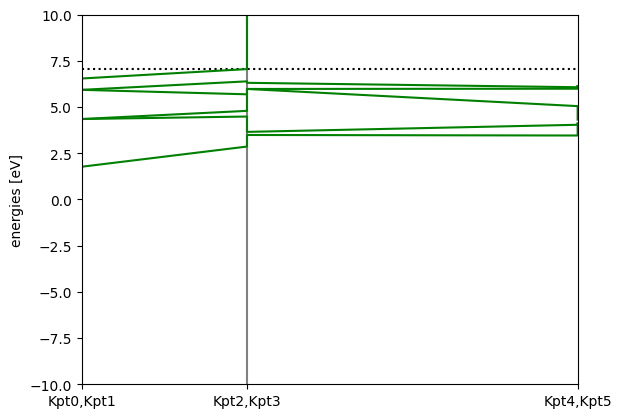

<Axes: ylabel='energies [eV]'>

In [26]:
bs = calc.band_structure()
bs.plot(filename='bandstructure1.png', show=True, emax=10.0)